In [24]:
from pyke import KeplerTargetPixelFile
%matplotlib inline

In [25]:
import numpy as np

In [26]:
import matplotlib.pyplot as plt

In [27]:
from oktopus import UniformPrior, JointPrior

In [28]:
from pyke import PRFPhotometry, SceneModel
from pyke.utils import KeplerQualityFlags

In [29]:
tpf = KeplerTargetPixelFile('https://archive.stsci.edu/missions/k2/target_pixel_files/c12/246100000/99000/ktwo246199087-c12_lpd-targ.fits.gz',
                            quality_mask=KeplerQualityFlags.HARDEST_BITMASK)

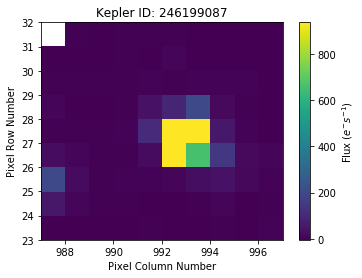

In [30]:
tpf.plot()

In [31]:
prf = tpf.get_prf_model()

In [32]:
prior_column = UniformPrior(lb=990, ub=996, name='column')
prior_row = UniformPrior(lb=25, ub=30, name='row')
prior_flux = UniformPrior(lb=4e3, ub=2e4, name='flux')
prior_bkg = UniformPrior(lb=1, ub=2e3, name='bkg')

In [33]:
prior = JointPrior(prior_flux, prior_column, prior_row, prior_bkg)

In [34]:
scene = SceneModel(prfs=[prf])

In [35]:
phot = PRFPhotometry(scene_model=scene, prior=prior)

In [36]:
results = phot.fit(tpf.flux + tpf.flux_bkg)

  0%|          | 0/3379 [00:00<?, ?it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in log
  return f_raw(*args, **kwargs)
 35%|███▍      | 1176/3379 [00:54<01:42, 21.40it/s]/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1850: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1851: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1
/Users/jvmirca/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1852: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = 2.0 * (tmp2 - tmp1)
100%|██████████| 3379/3379 [02:27<00:00, 22.93it/s]


In [37]:
flux = results[:, 0]
col = results[:, 1]
row = results[:, 2]
bkg = results[:, 3]

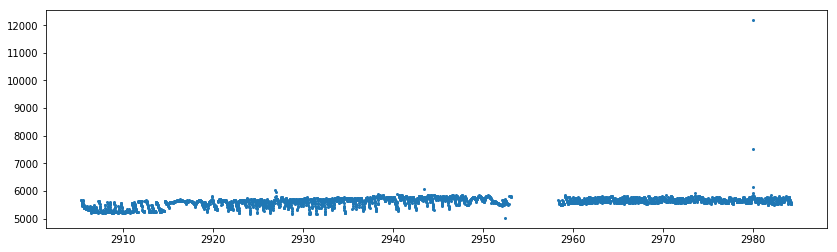

In [38]:
plt.figure(figsize=[14, 4])
plt.plot(tpf.time, flux, 'o', markersize=2)

In [39]:
q = tpf.time < 2956

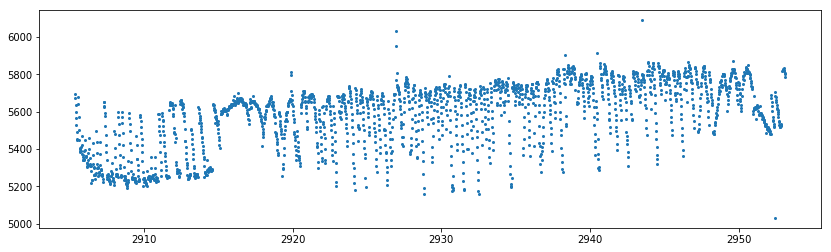

In [40]:
plt.figure(figsize=[14, 4])
plt.plot(tpf.time[q], flux[q], 'o', markersize=2)

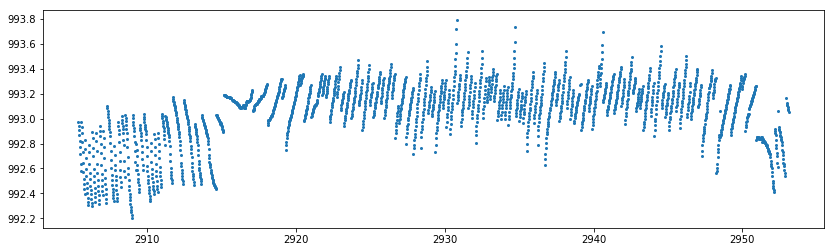

In [41]:
plt.figure(figsize=[14, 4])
plt.plot(tpf.time[q], col[q], 'o', markersize=2)

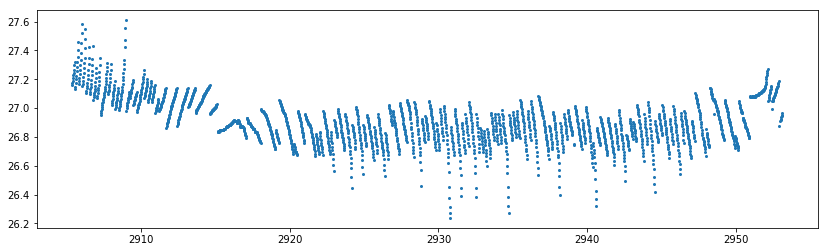

In [42]:
plt.figure(figsize=[14, 4])
plt.plot(tpf.time[q], row[q], 'o', markersize=2)

In [65]:
from pyke.lightcurve import SFFDetrender

/Users/jvmirca/dev/PyKE/pyke/lightcurve.py:524: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(rot_row, rot_col, self.poly_order)


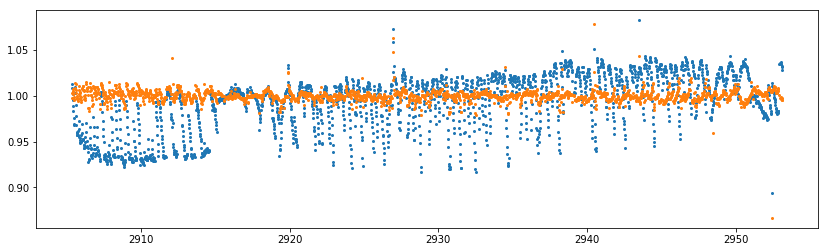

In [66]:
flux_detrended = SFFDetrender(niters=5).detrend(tpf.time[q], flux[q], col[q], row[q])
plt.figure(figsize=[14, 4])
plt.plot(tpf.time[q], flux[q]/np.median(flux[q]), 'o', markersize=2)
plt.plot(tpf.time[q], flux_detrended, 'o', markersize=2)

/Users/jvmirca/dev/PyKE/pyke/lightcurve.py:524: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(rot_row, rot_col, self.poly_order)


(0.9, 1.1)

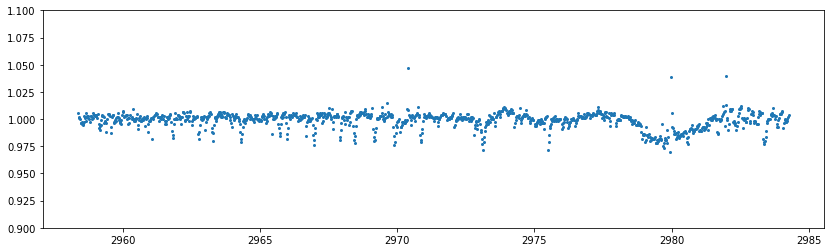

In [70]:
flux_detrended = SFFDetrender(niters=5).detrend(tpf.time[~q], flux[~q], col[~q], row[~q])
plt.figure(figsize=[14, 4])
#plt.plot(tpf.time[~q], flux[~q]/np.median(flux[~q]), 'o', markersize=2)
plt.plot(tpf.time[~q], flux_detrended, 'o', markersize=2)
plt.ylim(.9, 1.1)